# Datasci207-Group-Project-Team-RIMS 
## Hotel Cancellation - Baseline Model

### Import libraries

In [6]:
%reset -f
from __future__ import print_function

import math
import numpy as np
import numpy.linalg as nla
import pandas as pd
import re
import six
from os.path import join
from matplotlib import pyplot as plt

import seaborn as sns  # for nicer plots
sns.set(style="darkgrid")  # default style
from sklearn.model_selection import train_test_split
import tensorflow as tf
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler

# !pip uninstall scikit-learn --yes
# !pip uninstall imblearn --yes
# !pip install scikit-learn==1.2.2
# !pip install imblearn
import sklearn
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

# !pip install gdown
import gdown
import os

sklearn.__version__

'1.2.2'

### Read in processed data from EDA

In [41]:
# Recall that EDA saved the split data for sharing (after necessary engineering such as regrouping, get_dummies, but before standarization or removing some categorical features)
file_path = '../data/data-processed/'

X_train = pd.read_csv(file_path+'X_train.csv', index_col=0)
X_val = pd.read_csv(file_path+'X_val.csv', index_col=0)
X_test= pd.read_csv(file_path+'X_test.csv', index_col=0)
Y_train = pd.read_csv(file_path+'Y_train.csv', index_col=0).squeeze()
Y_val = pd.read_csv(file_path+'Y_val.csv', index_col=0).squeeze()
Y_test = pd.read_csv(file_path+'Y_test.csv', index_col=0).squeeze()

numeric_features = ['no_of_adults',
 'no_of_children',
 'no_of_weekend_nights',
 'no_of_week_nights',
 'lead_time',
 'no_of_previous_cancellations',
 'no_of_previous_bookings_not_canceled',
 'avg_price_per_room',
 'no_of_special_requests']

excluded_features = ['Booking_ID', 'arrival_year'] 
cat_features = ['type_of_meal_plan', 
                'room_type_reserved',  
                'market_segment_type', 
                'repeated_guest', 
                'required_car_parking_space', 
                'arrival_month', 
                'arrival_date', 
                'arrival_week_of_day']

### Further feature engineering for modeling purpose

In [43]:
# Standardize data (only numerical features)
X_train_std = X_train.copy()
X_val_std = X_val.copy()
X_test_std = X_test.copy()

X_train_std[numeric_features] = (X_train[numeric_features] - X_train[numeric_features].mean())/X_train[numeric_features].std()
X_val_std[numeric_features] = (X_val[numeric_features] - X_train[numeric_features].mean())/X_train[numeric_features].std()
X_test_std[numeric_features] = (X_test[numeric_features] - X_train[numeric_features].mean())/X_train[numeric_features].std()

print ('Check the description of the post standarization of X_train_std')
display(X_train_std[numeric_features].describe())
display(X_val_std[numeric_features].describe())

print (f'\nThe shape of X_train_std after standarization is {X_train_std.shape}')
print (f'The shape of X_val_std after standarization is {X_val_std.shape}')
print (f'The shape of X_test_std after standarization is {X_test_std.shape}')


# Treat data imbalance
oversample_ob = RandomOverSampler(random_state=1234, sampling_strategy = 'minority')
X_train_std_os, Y_train_os = oversample_ob.fit_resample(X_train_std, Y_train)
# IN: if we do not want to do oversampling
# X_train_std_os, Y_train_os = X_train_std, Y_train

print (f'\nThe shape of X_train_std_os after sample imbalance treatment is {X_train_std_os.shape}')
print (f'The shape of Y_train_os after sample imbalance treatment is {Y_train_os.shape}')
display(Y_train_os.value_counts())

# Change all inputs as numerical for ML to work
X_train_std_os, Y_train_os, X_val_std, Y_val, X_test_std, Y_test = \
    X_train_std_os.astype(float), Y_train_os.astype(float), X_val_std.astype(float), Y_val.astype(float), X_test_std.astype(float), Y_test.astype(float)

# Comments on oversampling
print ('\nReasoning for using oversampling:')
print ('Note that we did seperate alternative experiment, where we do not conduct oversampling in train data.')
print ('As it turns out, although we see slightly higher overall accuracy results (~80.5% for train) but large by group accuracy where the minority group - cancellation group has accuracy of 65.5%,')
print ('While the majority group - non-cancellation group has accuracy of 88.1% in train. Therefore, we decided to use oversampling for most of our models from here on.')

Check the description of the post standarization of X_train_std


,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,lead_time,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests
count,2.176500e+04,2.176500e+04,2.176500e+04,2.176500e+04,2.176500e+04,2.176500e+04,2.176500e+04,2.176500e+04,2.176500e+04
mean,-1.111600e-16,1.501721e-17,3.101381e-17,-5.729394e-17,-9.238851e-17,-1.175260e-17,-4.570456e-18,-1.939179e-16,3.362550e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-3.562819e+00,-2.663556e-01,-9.345568e-01,-1.573812e+00,-9.962975e-01,-6.336118e-02,-8.602559e-02,-2.965883e+00,-7.871379e-01
25%,2.911025e-01,-2.663556e-01,-9.345568e-01,-8.579347e-01,-7.975669e-01,-6.336118e-02,-8.602559e-02,-6.627853e-01,-7.871379e-01
50%,2.911025e-01,-2.663556e-01,2.178868e-01,-1.420572e-01,-3.299656e-01,-6.336118e-02,-8.602559e-02,-1.126804e-01,-7.871379e-01
75%,2.911025e-01,-2.663556e-01,1.370330e+00,5.738203e-01,4.883367e-01,-6.336118e-02,-8.602559e-02,4.930660e-01,4.849185e-01
max,4.145024e+00,7.388437e+00,7.132548e+00,1.059611e+01,4.182387e+00,3.495173e+01,3.220542e+01,1.252195e+01,5.573144e+00


,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,lead_time,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests
count,7255.000000,7255.000000,7255.000000,7255.000000,7255.000000,7255.000000,7255.000000,7255.000000,7255.000000
mean,-0.031607,0.001993,-0.008790,0.025787,-0.000739,-0.002475,0.004221,-0.015698,-0.008825
std,0.999985,1.022447,1.004429,1.018810,1.008134,0.904644,0.974968,1.023698,0.992614
min,-3.562819,-0.266356,-0.934557,-1.573812,-0.996297,-0.063361,-0.086026,-2.965883,-0.787138
25%,0.291103,-0.266356,-0.934557,-0.857935,-0.797567,-0.063361,-0.086026,-0.671390,-0.787138
50%,0.291103,-0.266356,0.217887,-0.142057,-0.318276,-0.063361,-0.086026,-0.143369,-0.787138
75%,0.291103,-0.266356,1.370330,0.573820,0.464957,-0.063361,-0.086026,0.475857,0.484919
max,4.145024,7.388437,5.980105,10.596106,4.182387,34.951732,27.194676,7.502745,5.573144



The shape of X_train_std after standarization is (21765, 79)
The shape of X_val_std after standarization is (7255, 79)
The shape of X_test_std after standarization is (7255, 79)

The shape of X_train_std_os after sample imbalance treatment is (29216, 79)
The shape of Y_train_os after sample imbalance treatment is (29216,)


booking_status
0.0    14608
1.0    14608
Name: count, dtype: int64


Reasoning for using oversampling:
Note that we did seperate alternative experiment, where we do not conduct oversampling in train data.
As it turns out, although we see slightly higher overall accuracy results (~80.5% for train) but large by group accuracy where the minority group - cancellation group has accuracy of 65.5%,
While the majority group - non-cancellation group has accuracy of 88.1% in train. Therefore, we decided to use oversampling for most of our models from here on.


### Modeling - Baseline model (logistic regression) - tensor flow

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1)              │            72 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 72 (288.00 B)

 Trainable params: 72 (288.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
293/293 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - binary_accuracy: 0.6893 - loss: 0.6571 - recall: 0.7560 - recall_1: 0.0669 - val_binary_accuracy: 0.7435 - val_loss: 0.5861 - val_recall: 0.7766 - val_recall_1: 0.4255
Epoch 2/10
293/293 ━━━━━━━━━━━━━━━━━━━━ 0s 680us/step - binary_accuracy: 0.7546 - loss: 0.5664 - recall: 0.7635 - recall_1: 0.4678 - val_binary_accuracy: 0.7636 - val_loss: 0.5343 - val_recall: 0.7685 - val_recall_1: 0.5638
Epoch 3/10
293/293 ━━━━━━━━━━━━━━━━━━━━ 0s 744us/step - binary_accuracy: 0.7690 - loss: 0.5216 - recall: 0.7694 - recall_1: 0.5730 - val_binary_accuracy: 0.7712 - val_loss: 0.5053 - val_recall: 0.7723 - val_recall_1: 0.6174
Epoch 4/10
293/293 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step - binary_accuracy: 0.7748 - loss: 0.4955 - recall: 0.7728 - recall_1: 0.6203 - val_binary_accuracy: 0.7760 - val_loss: 0.4880 - val_recall: 0.7800 - val_recall_1: 0.6455
Epoch 5/10
293/293 ━━━━━━━━━━━━━━━━━━━━ 0s 823us/step - binary_accuracy: 0.7797 - loss: 0.4792 - recall: 0

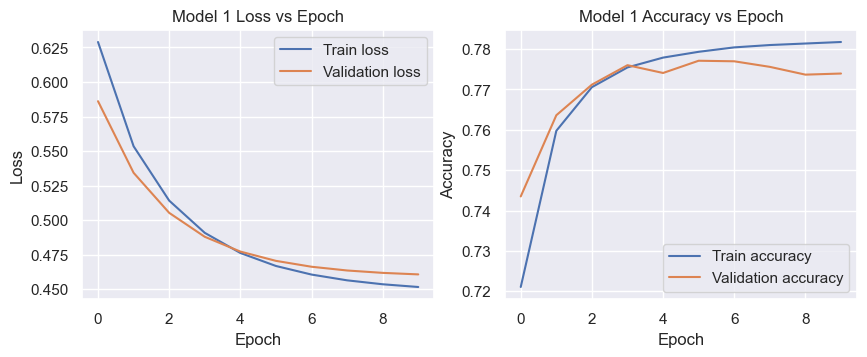

In [44]:
# YOUR CODE HERE
def build_model_lr(num_features, learning_rate):
  """Build a TF linear regression model using Keras.

  Args:
    num_features: The number of input features.
    learning_rate: The desired learning rate for SGD.

  Returns:
    model: A tf.keras model (graph).
  """
  tf.keras.backend.clear_session()
  tf.random.set_seed(0)

  # Build a model using keras.Sequential. 
  model = tf.keras.Sequential()
  # IN: initiate an input layer seperately as the warning suggested
  model.add(tf.keras.Input(shape=(num_features,), 
                           name = 'Input'))
  model.add(tf.keras.layers.Dense(
      units=1,        # output dim
      use_bias=True,               # use a bias (intercept) param
      activation='sigmoid',
      kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.01),  # use random
      bias_initializer=tf.keras.initializers.RandomNormal(stddev=0.01),    # initialize bias to 1
  ))

  # We need to choose an optimizer. We'll use SGD, which is actually mini-batch SGD
  optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)

  # Finally, compile the model. Select the accuracy metric. This finalizes the graph for training.
  model.compile(
      loss = tf.keras.losses.BinaryCrossentropy(),
      optimizer = optimizer,
      metrics = [tf.keras.metrics.BinaryAccuracy(),
                 tf.keras.metrics.Recall(thresholds=0.5),
                 tf.keras.metrics.Recall(thresholds=0.6)]
      # metrics = ['accuracy']
  )
    
  return model

# Build the model - logistic regression
# IN: we drop one column per categorical variable to avoid perfect multi-collinearity issue for logistic regression given it is still a afine model
drop_feat_lr = ['type_of_meal_plan_Meal Plan 3', 'room_type_reserved_Room_Type 3', 'market_segment_type_Aviation', 'repeated_guest_1', 'required_car_parking_space_1',\
                'arrival_month_1', 'arrival_date_31', 'arrival_week_of_day_0']
model1 = build_model_lr(X_train_std_os.drop(columns=drop_feat_lr).shape[1], learning_rate = 0.001)
model1.summary()

# Fit the model
mod_res1 = model1.fit(
    x = X_train_std_os.drop(columns=drop_feat_lr),
    y = Y_train_os,
    validation_data = [X_val_std.drop(columns=drop_feat_lr), Y_val],
    batch_size = 100,
    epochs = 10,
    verbose = 1
)

# IN: plot the results - Training and validation loss through epochs
def plot_model_res_binary(res, model_name, recall_flag=False):
    fig, ax = plt.subplots(1,2, figsize = (10,3.5))
    ax[0].plot(res.history['loss'], label='Train loss')
    ax[0].plot(res.history['val_loss'], label='Validation loss') # val_loss is the validation/test data
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].set_title(model_name + ' Loss vs Epoch')
    # ax[0].set_ylim((0,1))
    ax[0].legend()

    if recall_flag is False:
      ax[1].plot(res.history['binary_accuracy'], label='Train accuracy')
      ax[1].plot(res.history['val_binary_accuracy'], label='Validation accuracy') # val_loss is the validation/test data
      ax[1].set_xlabel('Epoch')
      ax[1].set_ylabel('Accuracy')
      ax[1].set_title(model_name + ' Accuracy vs Epoch')
      # ax[1].set_ylim((0.7,0.8))
      ax[1].legend()

    else:
      ax[1].plot(res.history['recall'], label='Train recall - 0.5')
      ax[1].plot(res.history['val_recall'], label='Validation recall - 0.5') # val_loss is the validation/test data
      ax[1].set_xlabel('Epoch')
      ax[1].set_ylabel('Recall_0.5_threshold')
      ax[1].set_title(model_name + ' Recall vs Epoch')
      # ax[1].set_ylim((0.7,0.8))
      ax[1].legend()     

    plt.grid(True)
    plt.show()
    plt.close()
    return 

# Plot the model results
plot_model_res_binary(mod_res1, 'Model 1', recall_flag=False)

# print ('Comments: from the chart we can see that with learning rate of 0.0001, batch size of 32 and epochs of 10, both training and validation data loss are still on sharp declining trend,', end='\n')
# print ('and both train and validation accuracies are still clibming. This suggests that the current combination is not ideal for training, the model still has more room to improve. ', end='\n')
# print ('It is most likely due to too small of a learning rate, too few iteration (epoch x the iterations per epoch) or the combination of both.')
# print ('Therefore we aim to tune those hyperparameters in the following section.')

In [45]:
# Tune our baseline model 
print ('1. Fine-tune the hyperparameters (learning rate, number of epochs, mini sgd batch size), by trying a few different combinitions and evaluate the results, comparing F1:')

# Going through different combinations of hyperparameters to compare their final epoch loss (for training and validation groups)
learning_rate_l = [0.001, 0.005]
batch_size_l = [50,100,200]
epoch_l = [5,10,20]

loss_train_l = []
loss_val_l = []
accuracy_train_l = []
accuracy_val_l = []
f1_train_l = []
f1_val_l = []
param_dic = {}
count = 0
for learning_rate_t in learning_rate_l:
    for batch_size_t in batch_size_l:
        for epoch_t in epoch_l:
            model_t = build_model_lr(num_features=X_train_std_os.drop(columns=drop_feat_lr).shape[1], learning_rate=learning_rate_t)
            mod1_res_t = model_t.fit(
                    x=X_train_std_os.drop(columns=drop_feat_lr), y=Y_train_os,
                    validation_data=[X_val_std.drop(columns=drop_feat_lr), Y_val],
                    batch_size=batch_size_t,
                    epochs=epoch_t,
                    verbose=1)       
            param_dic[count] = (learning_rate_t, batch_size_t, epoch_t)
            # Calculate F1
            Y_pred_train_t = np.where((model_t.predict(X_train_std_os.drop(columns=drop_feat_lr))).flatten()>0.5,1,0)
            Y_pred_val_t = np.where(model_t.predict(X_val_std.drop(columns=drop_feat_lr)).flatten()>0.5,1,0)
            f1_train_l.append(metrics.f1_score(Y_train_os, Y_pred_train_t))
            f1_val_l.append(metrics.f1_score(Y_val, Y_pred_val_t))

            loss_train_l.append(mod1_res_t.history['loss'][-1])   
            loss_val_l.append(mod1_res_t.history['val_loss'][-1]) 
            accuracy_train_l.append(mod1_res_t.history['binary_accuracy'][-1])   
            accuracy_val_l.append(mod1_res_t.history['val_binary_accuracy'][-1]) 
            count +=1

1. Fine-tune the hyperparameters (learning rate, number of epochs, mini sgd batch size), by trying a few different combinitions and evaluate the results, comparing F1:
Epoch 1/5
585/585 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - binary_accuracy: 0.7061 - loss: 0.6369 - recall: 0.7264 - recall_1: 0.1492 - val_binary_accuracy: 0.7675 - val_loss: 0.5390 - val_recall: 0.7643 - val_recall_1: 0.5443
Epoch 2/5
585/585 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step - binary_accuracy: 0.7709 - loss: 0.5208 - recall: 0.7668 - recall_1: 0.5721 - val_binary_accuracy: 0.7753 - val_loss: 0.4918 - val_recall: 0.7757 - val_recall_1: 0.6340
Epoch 3/5
585/585 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step - binary_accuracy: 0.7779 - loss: 0.4818 - recall: 0.7728 - recall_1: 0.6419 - val_binary_accuracy: 0.7762 - val_loss: 0.4733 - val_recall: 0.7702 - val_recall_1: 0.6660
Epoch 4/5
585/585 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step - binary_accuracy: 0.7821 - loss: 0.4650 - recall: 0.7765 - recall_1: 0.6675 - val_binary_accuracy: 0.7782 - val

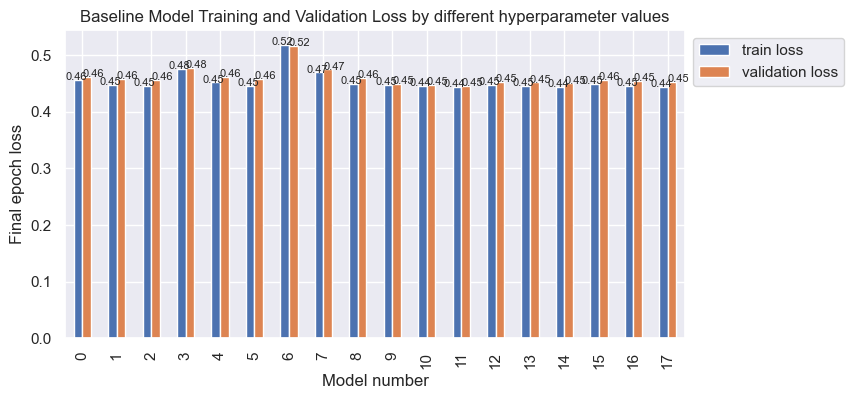

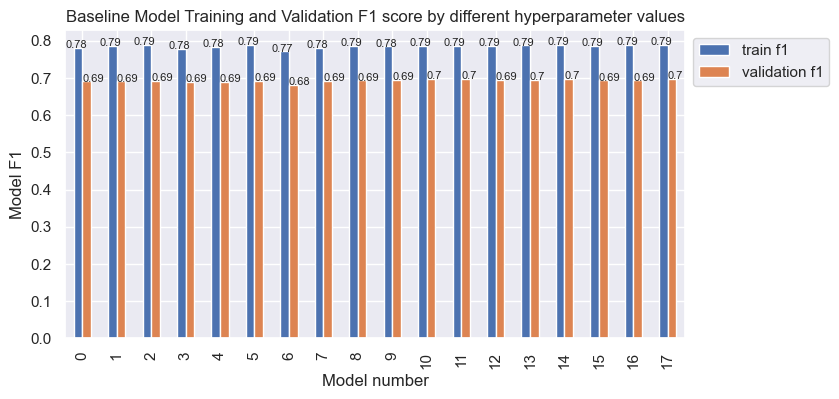

The model configerations are as below:


,Learning_rate,Batch_size,Epoch
0,0.001,50.0,5.0
1,0.001,50.0,10.0
2,0.001,50.0,20.0
3,0.001,100.0,5.0
4,0.001,100.0,10.0
5,0.001,100.0,20.0
6,0.001,200.0,5.0
7,0.001,200.0,10.0
8,0.001,200.0,20.0
9,0.005,50.0,5.0



In order to balance the convergence results and convergence speed (the number of iterations and epoch it takes to converge), I will choose Model 10, which has the hyperparameters 
as below: learning_rate = 0.005, batch_size = 50, epoch=10.


In [46]:
# Plot the results and comment on the results - Loss
loss_df = pd.DataFrame(np.concatenate([np.array(loss_train_l)[:,None], np.array(loss_val_l)[:,None]], axis=1), columns = ['train loss', 'validation loss'])
fig3 = plt.figure(figsize=(8,4))
ax3 = fig3.add_subplot()
loss_df.plot.bar(ax=ax3, title='Baseline Model Training and Validation Loss by different hyperparameter values')
ax3.set_xlabel('Model number')
ax3.set_ylabel('Final epoch loss')

for i in range(len(loss_df.iloc[:,0])):
    if loss_df.loc[i, 'train loss'] <= 1.0:
        ax3.text(i-0.5, loss_df.loc[i, 'train loss'], str(round(loss_df.loc[i, 'train loss'],2)), fontsize=8)
        ax3.text(i, loss_df.loc[i, 'validation loss'], str(round(loss_df.loc[i, 'validation loss'],2)), fontsize=8)
plt.legend(bbox_to_anchor=(1,1))
plt.show()

# Plot the results and comment on the results - F1
f1_df = pd.DataFrame(np.concatenate([np.array(f1_train_l)[:,None], np.array(f1_val_l)[:,None]], axis=1), columns = ['train f1', 'validation f1'])
fig4 = plt.figure(figsize=(8,4))
ax4 = fig4.add_subplot()
f1_df.plot.bar(ax=ax4, title='Baseline Model Training and Validation F1 score by different hyperparameter values')
ax4.set_xlabel('Model number')
ax4.set_ylabel('Model F1')

for i in range(len(loss_df.iloc[:,0])):
    if f1_df.loc[i, 'train f1'] <= 1.0:
        ax4.text(i-0.5, f1_df.loc[i, 'train f1'], str(round(f1_df.loc[i, 'train f1'],2)), fontsize=8)
        ax4.text(i, f1_df.loc[i, 'validation f1'], str(round(f1_df.loc[i, 'validation f1'],2)), fontsize=8)
plt.legend(bbox_to_anchor=(1,1))
plt.show()

print ('The model configerations are as below:')
pd.set_option('display.max_columns', 2000) 
display (pd.DataFrame(param_dic).T.rename(columns=dict(zip([0,1,2],['Learning_rate', 'Batch_size', 'Epoch']))))
print ('\nIn order to balance the convergence results and convergence speed (the number of iterations and epoch it takes to converge), I will choose Model 10, which has the hyperparameters ', end='\n')
print ('as below: learning_rate = 0.005, batch_size = 50, epoch=10.')

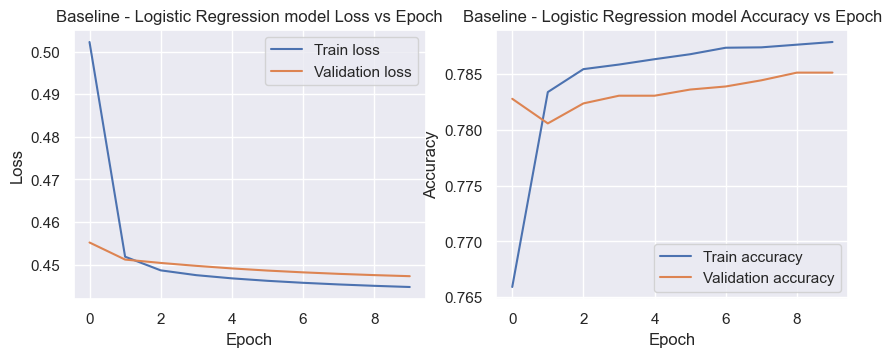

In [47]:
# Baseline chosen model results:
learning_rate_chosen = 0.005
batch_size_chosen = 50
epochs_chosen = 10

model2 = build_model_lr(X_train_std_os.drop(columns=drop_feat_lr).shape[1], learning_rate = learning_rate_chosen)

# YOUR CODE HERE
mod2_res = model2.fit(
    x = X_train_std_os.drop(columns=drop_feat_lr),
    y = Y_train_os,
    validation_data = [X_val_std.drop(columns=drop_feat_lr), Y_val],
    batch_size = batch_size_chosen,
    epochs = epochs_chosen,
    verbose = 0
)

plot_model_res_binary(mod2_res, 'Baseline - Logistic Regression model', recall_flag=False)

The top five weights are:
[1.516239   1.2542216  1.084124   0.8244976  0.801975   0.7759875
 0.5337062  0.4065284  0.37969527 0.3556971 ]

The top five bias are:
[-0.6923214]

The features with the top 5 weights in logistic regression are:


['lead_time',
 'arrival_month_2',
 'required_car_parking_space_0',
 'arrival_month_11',
 'arrival_month_3',
 'avg_price_per_room',
 'arrival_month_4',
 'arrival_month_10',
 'arrival_month_6',
 'arrival_date_28']

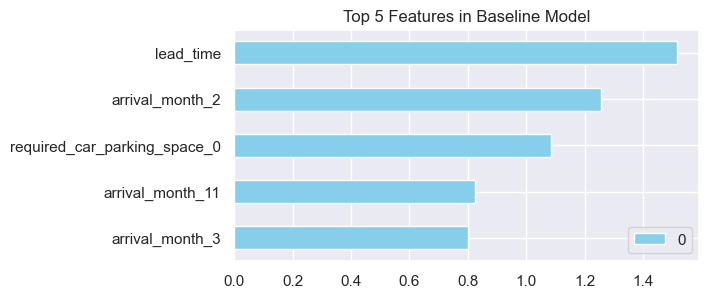

In [48]:
# Model weights for the chosen model
weights_lr, bias_lr = model2.layers[-1].get_weights()[0], model2.layers[-1].get_weights()[1]
feature_names_baseline = X_train_std_os.drop(columns=drop_feat_lr).columns
if (len(weights_lr) != len(feature_names_baseline)):
    raise ValueError ('Weights len does not equal to feature names len')

print ('The top five weights are:')
print (np.flip(np.sort(weights_lr.flatten()))[:10])
print ('\nThe top five bias are:')
print (np.flip(np.sort(bias_lr.flatten()))[:10])
print ('\nThe features with the top 5 weights in logistic regression are:')
display(feature_names_baseline[list(np.flip(np.argsort(weights_lr.flatten())))][:10].tolist())
pd.DataFrame(np.flip(np.sort(weights_lr.flatten()))[:5][::-1], feature_names_baseline[list(np.flip(np.argsort(weights_lr.flatten())))][:5][::-1])\
    .plot.barh(title='Top 5 Features in Baseline Model', figsize=(6,3), color = 'skyblue')
plt.show()

### Metrics

In [51]:
# Util functions for evaluation:

def confusion_matrix_plot(conf_matrix, plot_name):
    """ Confusion matrix matplotlib plot
    # param conf_matrix: nested list of TP, TN, FP, FN
    # return: None
    """
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.7)
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x=j, y=i, s=conf_matrix[i, j], va='center', ha='center')

    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title (plot_name)
    plt.tight_layout()
    plt.grid(False)
    plt.show()

def model_performance_metrics_comp (model, X, Y, class_names, binary_flag=False):
    Y_pred = model.predict(X)

    # to handle the situation where model predict are just probabilities and only two classes (such as softmax dense output neural network)
    if binary_flag:
        Y_pred = np.where(Y_pred>0.5, 1, 0)
    if binary_flag:
        average = None
    else:
        average = None
    
    cm = tf.math.confusion_matrix(
    Y,
    Y_pred,
    num_classes=None,
    weights=None,
    dtype=tf.dtypes.int32,
    name=None
    ).numpy()
    acc_by_class = np.array([cm[i,i]/cm[i].sum() for i in range(len(cm[0]))]) 

    acc = metrics.accuracy_score(Y, Y_pred)
    precision = metrics.precision_score(Y, Y_pred, average=average)
    recall = metrics.recall_score(Y, Y_pred, average=average)
    f1 = metrics.f1_score(Y, Y_pred, average=average)

    res_df = pd.DataFrame(np.concatenate([[acc_by_class, precision, recall, f1]], axis=0), \
                          index = ['Accuracy by class','Precision', 'Recall', 'F1'], \
                            columns=class_names)

    return (acc, res_df)

Prepare model results for baseline model:
913/913 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/step

For train data:
The overall accuracy is: 78.8%
The by class metrics are: 


,Non_cancellation,Cancellation
Accuracy by class,79.9%,77.7%
Precision,78.2%,79.5%
Recall,79.9%,77.7%
F1,79.0%,78.6%


227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step

For validation data:
The overall accuracy is: 78.5%
The by class metrics are: 


,Non_cancellation,Cancellation
Accuracy by class,79.5%,76.4%
Precision,87.5%,64.1%
Recall,79.5%,76.4%
F1,83.3%,69.7%


227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step

For test data:
The overall accuracy is: 78.5%
The by class metrics are: 


,Non_cancellation,Cancellation
Accuracy by class,80.0%,75.6%
Precision,87.0%,64.8%
Recall,80.0%,75.6%
F1,83.4%,69.8%


227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step


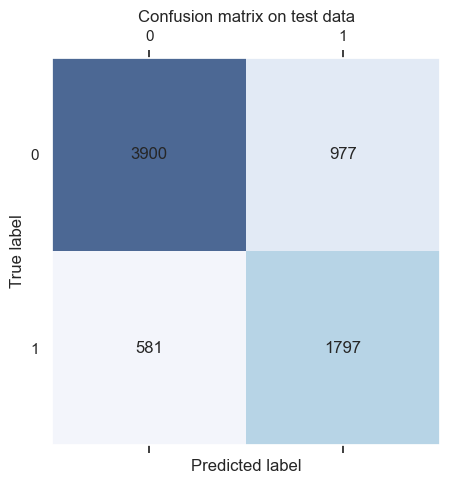

The overall accuracy on train data is 78.5%
The overall accuracy on validation data is 78.5%
The overall accuracy on test data is 78.5%

1.The TP is 3900, TN is 1797, FP is 977, FN is 581.

2.The accuracy for cancellation group is 75.6%, and the accuracy for non-cancellation group is 80.0%.
3.The precision for cancellation group is 64.8%, the recall for cancellation group is 75.6%, and f1 for cancellation group is 69.8%.


In [50]:
'''Metrics calculation on train, validation and test sets for baseline model'''
print ('Prepare model results for baseline model:')
(acc_train_lr, res_df_train_lr) = model_performance_metrics_comp (model2, X_train_std_os.drop(columns=drop_feat_lr), Y_train_os, \
                                                             ['Non_cancellation', 'Cancellation'], binary_flag = True)
print ('\nFor train data:')
print (f'The overall accuracy is: {acc_train_lr:.1%}')
print ('The by class metrics are: ')
display(res_df_train_lr.apply(lambda x: x.map('{:.1%}'.format)))

(acc_val_lr, res_df_val_lr) = model_performance_metrics_comp (model2, X_val_std.drop(columns=drop_feat_lr), Y_val, \
                                                             ['Non_cancellation', 'Cancellation'], binary_flag = True)
print ('\nFor validation data:')
print (f'The overall accuracy is: {acc_val_lr:.1%}')
print ('The by class metrics are: ')
display(res_df_val_lr.apply(lambda x: x.map('{:.1%}'.format)))

(acc_test_lr, res_df_test_lr) = model_performance_metrics_comp (model2, X_test_std.drop(columns=drop_feat_lr), Y_test, \
                                                             ['Non_cancellation', 'Cancellation'], binary_flag = True)
print ('\nFor test data:')
print (f'The overall accuracy is: {acc_test_lr:.1%}')
print ('The by class metrics are: ')
display(res_df_test_lr.apply(lambda x: x.map('{:.1%}'.format)))

'''Comments and confusion matrix'''
'''confusion matrix plot on test data'''
Y_test_pred = np.where(model2.predict(x=X_test_std.drop(columns=drop_feat_lr)).flatten()>0.5,1,0)

conf_matrix_test = tf.math.confusion_matrix(
    Y_test,
    Y_test_pred,
    num_classes=None,
    weights=None,
    dtype=tf.dtypes.int32,
    name=None
)
conf_matrix_test

confusion_matrix_plot(conf_matrix_test.numpy(), 'Confusion matrix on test data')
print (f'The overall accuracy on train data is {acc_val_lr:.1%}')
print (f'The overall accuracy on validation data is {acc_val_lr:.1%}')
print (f'The overall accuracy on test data is {acc_test_lr:.1%}')

cancel_accuracy_lr = res_df_test_lr.loc['Accuracy by class','Cancellation']
non_cancel_accuracy_lr = res_df_test_lr.loc['Accuracy by class','Non_cancellation']
precision_lr = res_df_test_lr.loc['Precision','Cancellation']
recall_lr = res_df_test_lr.loc['Recall','Cancellation']
f1_lr = res_df_test_lr.loc['F1','Cancellation']

print (f'\n1.The TP is {conf_matrix_test.numpy()[0,0]}, TN is {conf_matrix_test.numpy()[1,1]}, FP is {conf_matrix_test.numpy()[0,1]}, FN is {conf_matrix_test.numpy()[1,0]}.')
print (f'\n2.The accuracy for cancellation group is {cancel_accuracy_lr:.1%}, and the accuracy for non-cancellation group is {non_cancel_accuracy_lr:.1%}.')
print (f'3.The precision for cancellation group is {precision_lr:.1%}, the recall for cancellation group is {recall_lr:.1%}, and f1 for cancellation group is {f1_lr:.1%}.')